In [1]:
import numpy as np
import os
import pandas as pd
import tools
from tqdm import tqdm
from matplotlib import pyplot as plt
import measures as ms
import seaborn as sns
import spatial_maps as sm
import plot

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from scipy.ndimage import gaussian_filter

# install Rtrack
rtrack = importr('Rtrack')
rstatix = importr('rstatix')

%load_ext autoreload
%autoreload 2

Warning message:
D-Bus service not found!

- If you are in a container environment, please consider adding the
  following to your configuration to silence this warning:

  options(bspm.sudo = TRUE)

- If you are in a desktop/server environment, please remove any 'bspm'
  installation from the user library and force a new system
  installation as follows:

  $ sudo Rscript --vanilla -e 'install.packages("bspm", repos="https://cran.r-project.org")' 


## Params

In [2]:
path_exp = "/home/jovyan/data/PNN.A-CMWMRawData/"
path_probe_trials = "PNN.A-C.MWM.probe/"
path_train_trials = ["PNN.A-C.MWM.REV.Train/",]

fname_genotypes = "MWMGenotypes.xlsx"

#radius platform in cm
r_platform = 6

# correct the estimated radius of the maze by a small percentage
r_maze_corr = 1.03

## Load metadata

In [3]:
# metadata of each recording
df_info_probe = tools.load_finfo_probe(path_exp+path_probe_trials)
df_info_probe['day'] = "probe"
df_info_train = tools.load_finfo_train(path_exp+path_train_trials[0])

df_info = pd.concat([df_info_probe, df_info_train])

# genotype data for each individual
def handle_values(val):
    if isinstance(val, str) and '*' in val:
        return val.replace('*', '')  # Replace '*' with an empty string
    return val
df_genotypes = pd.read_excel(path_exp+fname_genotypes, converters={'Subj': handle_values}, usecols=[0, 1, 2])
df_genotypes.set_index('Subj', inplace=True)

# merge both
df_info = pd.merge(df_info, df_genotypes[['sex', 'Geno']], left_on='animal_id', right_index=True, how='left')
df_info.reset_index(drop=True, inplace=True)

In [4]:
# add experimental day
df_info['exp_day'] = np.nan

# 1. during HID phase
sel = ((df_info['phase'] == 'HID') & (df_info['day'] == 'probe'))
df_info.loc[sel, 'exp_day'] = 5

# 2. during Rev phase
# a) training
sel = ((df_info['phase'] == 'REV') & (df_info['day'] != 'probe'))
df_info.loc[sel, 'exp_day'] = df_info.loc[sel, 'day'].astype(int)+5

# b) probe
sel = ((df_info['phase'] == 'REV') & (df_info['day'] == 'probe'))
df_info.loc[sel, 'exp_day'] = 14

### Extract old platform location based on probe trial from initial learning.
The data does not explicitly state the location of the old platform during reversal learning.
Therefore we take the position of the non-existing platform of the probe trial.

In [5]:
idx_hid_probe = (
    (df_info['phase']=='HID') &
    (df_info['day'] == 'probe'))
df_info_hid_prob = df_info[idx_hid_probe][['animal_id', 'platform_pos']]
df_info_hid_prob.rename(columns={'platform_pos': 'xy_pltfrm_old'}, inplace=True)
df_info = df_info.merge(df_info_hid_prob, on='animal_id', how='left')

# for correctnes
df_info.loc[idx_hid_probe, 'xy_pltfrm_old'] = np.nan

In [6]:

# Enable ordering across experimental type, day and trial
ls_df_info_i = []
for i in df_info['animal_id'].unique():
    df_info_i = df_info[df_info['animal_id'] == i]
    df_info_i = df_info_i.sort_values(['Geno', 'phase', 'day', 'trial'])
    df_info_i['order'] = np.arange(len(df_info_i))
    df_info_i['grp_day_trial'] = df_info_i['phase'] + '_' + df_info_i['day'].astype(str) + '_' + df_info_i['trial'].astype(str)
    df_info_i['grp_day'] = df_info_i['phase'] + '_' + df_info_i['day'].astype(str)
    ls_df_info_i.append(df_info_i)
df_info = pd.concat(ls_df_info_i)
df_info = df_info.reset_index(drop=True)

## Estimate box boundaries based on trajectory (preferred for now)

In [7]:
bool_display = False

# points to plot
ls_pts = ['platform_pos', 'Q1', 'Q2', 'Q3', 'Q4',]

gp_pts = df_info.groupby(ls_pts)
for i, gp_i in tqdm(gp_pts):  
    ls_xy = []
    for j, row_j in gp_i.iterrows():
        # load recording
        path_j = row_j['relative_path']
        rec = tools.load_recording(path_j)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        ls_xy.append(xy)
    xy_all = np.vstack(ls_xy)

    # estimate center and radius based on max/min in x and y.
    center_x, center_y, radius = tools.detect_circle_boundaries(xy_all[:, 0], xy_all[:, 1])

    # apply correction factor
    radius = radius * r_maze_corr
    
    # store in dataframe
    df_info.loc[gp_i.index, 'center_x'] = center_x
    df_info.loc[gp_i.index, 'center_y'] = center_y
    df_info.loc[gp_i.index, 'radius'] = radius
    
    if bool_display:
        # Create a scatter plot
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.scatter(xy_all[:, 0], xy_all[:, 1], s=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(i)
    
        # plot cirlce
        circle_wall = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        ax.add_patch(circle_wall)
    
        # plot platform
        circle_pltfrm = plt.Circle(i[0], r_platform, color='red', fill=False)
        ax.add_patch(circle_pltfrm)
    
        # plot quadrant points
        for j in range(1,5):
            circle_pltfrm = plt.Circle(i[j], 1, color='orange', fill=True)
            ax.add_patch(circle_pltfrm)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(i)
        plt.legend()
        plt.grid(True)
        plt.show()


100%|███████████████████████████████████████████████████████████████████| 25/25 [02:53<00:00,  6.96s/it]


## Compute measures and occupancy map

In [8]:
# define bins for occupancy maps
r_pool = df_info['radius'].mean()

dx = 2.5 # resolution of spatial occupancy map in cm
bins = np.arange(-r_pool*1.5, (r_pool+dx)*1.5, dx)

In [9]:
ls_res = []

for i, row_i in tqdm(df_info.iterrows()):
    # load recording
    path_i = row_i['relative_path']
    rec = tools.load_recording(path_i)
    # extract positions
    x, y = np.array(rec['X center']), np.array(rec['Y center'])  
    xy = np.hstack([x, y])
    xy_normalized = np.hstack(
        [x-row_i['center_x'],
         y-row_i['center_y']])

    # extract trial time
    t_trial = np.array(rec['Trial time']).flatten()
    # get recording time
    t_rec = np.array(rec['Recording time']).flatten()

    
    # compute measures
    # ----------------------
    res = {}
    
    # trial duration
    res['trial duration'] = np.max(t_trial)
    
    # path length
    res['path length'] = ms.path_length(xy)
    
    # mean distance to platform          
    res['mean distance to center of platform'
       ] = ms.mean_distance_to_point(xy, t_rec, row_i['platform_pos'])

    # mean distance to platform center of previous platform location
    res['mean distance to center of previous platform location'
       ] = ms.mean_distance_to_point(xy, t_rec, row_i['xy_pltfrm_old'])

    #  fraction of time in target quadrant and opposite quadrant
    time_targetquadrant = ms.time_in_quadrant(xy_normalized, t_rec, np.sign(row_i['platform_pos']))
    res['fraction of time in target quadrant'] = time_targetquadrant/np.max(t_rec)

    time_oldtargetquadrant = ms.time_in_quadrant(xy_normalized, t_rec, np.sign(row_i['xy_pltfrm_old']))
    res['fraction of time in old target quadrant'] = time_oldtargetquadrant/np.max(t_rec)
    
    # occupancy maps
    occ_map = sm.maps._occupancy_map(
        xy_normalized[:,0],
        xy_normalized[:,1],
        t_rec,
        bins,
        bins
        )
    
    res['occupancy_map'] = occ_map

    ls_res.append(res)
df_res = pd.DataFrame(ls_res)

df_info = df_info.join(df_res)

1331it [03:02,  7.30it/s]


## Plot measures

In [10]:
# Define units for measures
dct_ms_units = {
    'trial duration': 'seconds',
    'path length': 'meter',
    'mean distance to center of platform': 'meter',
    'mean distance to center of previous platform location': 'meter',
    'fraction of time in target quadrant': '',
    'fraction of time in old target quadrant': '',
}

# define colors for each group
palette = sns.color_palette()
ls_palette = [palette[0], palette[1]]

In [21]:
df_info['exp_day'].unique()

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

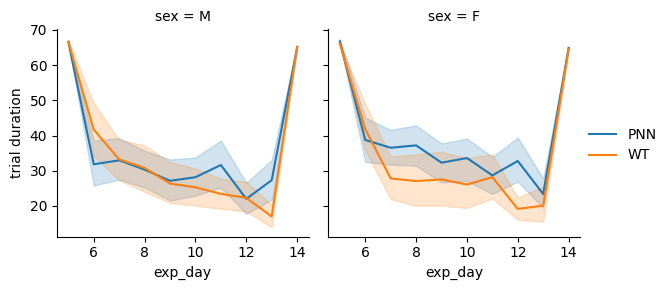

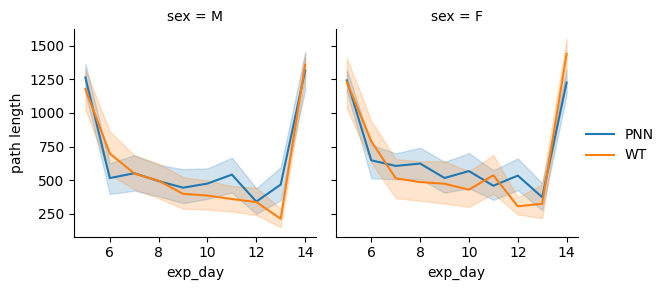

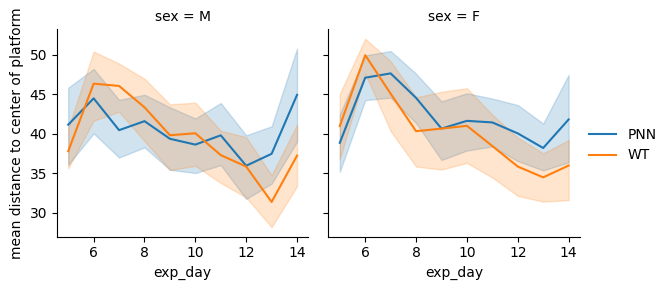

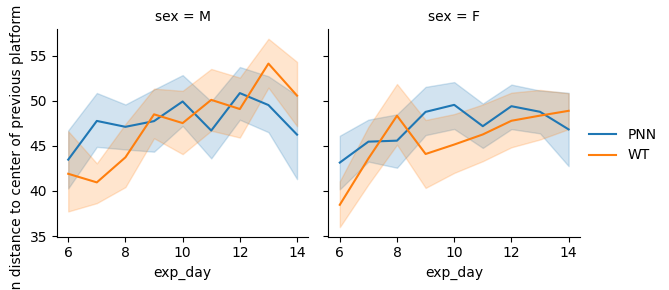

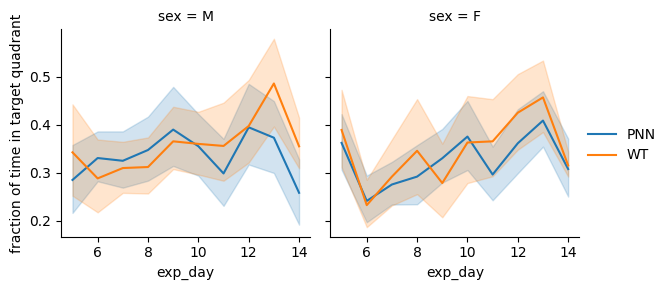

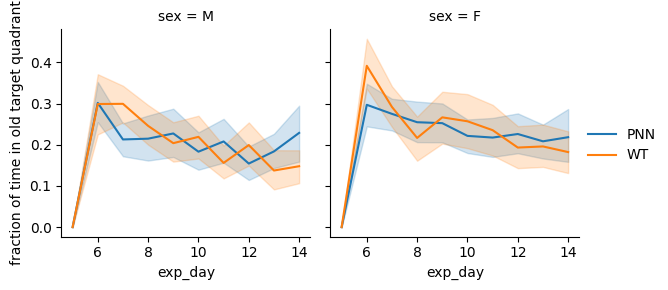

In [12]:
for ms in dct_ms_units.keys():
        
    df_i = df_info
    g = sns.FacetGrid(data=df_info, col="sex")
    
    # Map a bar plot of trial duration to each grid item
    g.map_dataframe(sns.lineplot, "exp_day", ms, hue='Geno')
    g.add_legend()


## Statistical analysis of reversal learning

In [13]:
df_info.iloc[0]

fname                                                                                PNN.C4.HID.PROBE.xlsx
relative_path                                            /home/jovyan/data/PNN.A-CMWMRawData/PNN.A-C.MW...
experiment                                                                                             PNN
animal_id                                                                                               C4
phase                                                                                                  HID
trial                                                                                                 None
cohort                                                                                                   C
platform_name                                                                                   Platform 1
platform_pos                                                                                 (1.53, 40.33)
Q1                                   

In [14]:
for sex_i in df_info['sex'].unique():
    for meas_i in dct_ms_units.keys():
        print('\n\n------------------------\n')
        print(meas_i + '\n')
    
        ls_sel = [
            meas_i,
            "animal_id",
            "day",
            "grp_day_trial",
            "sex",
            "Geno"]    
        df_sel = df_info[ls_sel]
        #select correct sex
        df_sel = df_sel[df_sel['sex']==sex_i]
        
        # exclude probe trials
        df_sel = df_sel[df_sel['day'] != 'probe']
    
        with localconverter(ro.default_converter + pandas2ri.converter):
            df_sel_r = ro.conversion.py2rpy(df_sel)

        aov = rstatix.anova_test(
            data=df_sel_r,
            dv=meas_i,
            wid='animal_id',
            within='grp_day_trial',
            between='Geno')

        with localconverter(ro.default_converter + pandas2ri.converter):
            aov_pd = ro.conversion.rpy2py(aov)
        print(aov_pd)



------------------------

trial duration

               Effect   DFn    DFd      F      p p<.05    ges
1                Geno   1.0   17.0  0.117  0.736        0.002
2       grp_day_trial  31.0  527.0  2.023  0.001     *  0.084
3  Geno:grp_day_trial  31.0  527.0  1.328  0.114        0.057


------------------------

path length

               Effect   DFn    DFd      F      p p<.05    ges
1                Geno   1.0   17.0  0.352  0.561        0.004
2       grp_day_trial  31.0  527.0  1.666  0.015     *  0.072
3  Geno:grp_day_trial  31.0  527.0  1.320  0.119        0.058


------------------------

mean distance to center of platform

               Effect   DFn    DFd      F         p p<.05       ges
1                Geno   1.0   17.0  0.010  0.922000        0.000159
2       grp_day_trial  31.0  527.0  2.739  0.000003     *  0.104000
3  Geno:grp_day_trial  31.0  527.0  0.920  0.594000        0.038000


------------------------

mean distance to center of previous platform location


## Occupancy map

In [16]:
### Params
dct_treat = {
    r'PNN removed': 'PNN',
    r'control': 'WT'}
vmin = 0.
vmax = 0.08*(dx*100)**2
dct_kwargs = {
    'subplots': {
        'figsize': (5, 10),
        'gridspec_kw': {
            'wspace':0.04,
            'hspace':0.04,
            'width_ratios': [0.3, 0.35, 0.35]}
    },
    'imshow': {
        'vmin': vmin,
        'vmax': vmax,
        'extent': [
            -r_pool,
            r_pool,
            -r_pool,
            r_pool]
    },
    'colorbar': {
        'orientation': 'horizontal',
        'ticks': [vmin, vmax],
        'label': r'Occupancy $\frac{s}{cm²}$'
    }
}

fac_scale_border = 1.1
fac_scale_pltfrm = 1.5


In [17]:
# Calculate average maps across treatment and days
ls_group_vars = ['exp_day', 'Geno', 'sex']
grps = df_info.groupby(ls_group_vars)
ls_res = []
for grp_i, grp_val in grps:
    res = {}
    occ_map = np.mean(np.dstack(grp_val['occupancy_map']), axis=2)

    # filter image
    occ_map = gaussian_filter(occ_map, 1)
    
    # mark values outside of pool with nan
    #map_dist_center = np.sqrt(np.add.outer(bins**2, bins**2))
    #bool_bin_in_pool = map_dist_center<r_pool
    #occ_map = np.ma.masked_where(
    #    ~bool_bin_in_pool[1:, 1:], occ_map)
    
    res['occupancy_map'] = occ_map
    res['n_animals'] = len(grp_val['animal_id'].unique())
    res['n_trials'] = len(grp_val)
    
    for j, var_j in enumerate(ls_group_vars):
        res[var_j] = grp_i[j]
    ls_res.append(res)
df_meanmap = pd.DataFrame(ls_res)


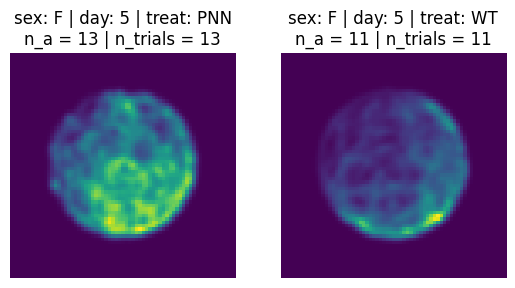

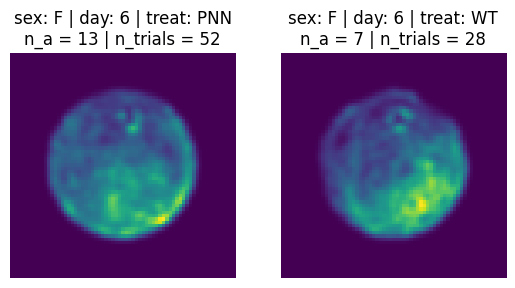

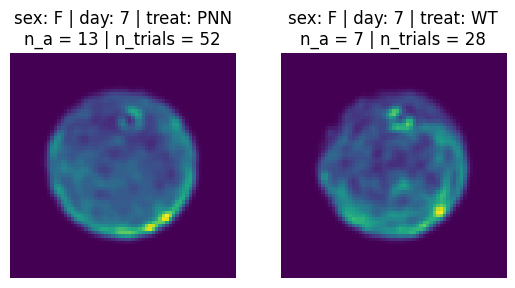

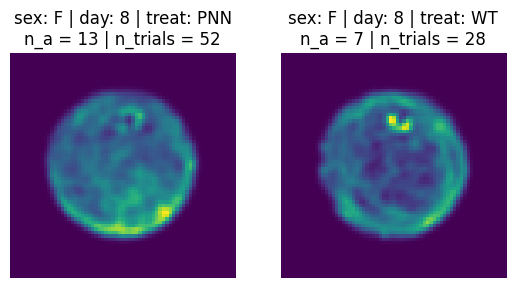

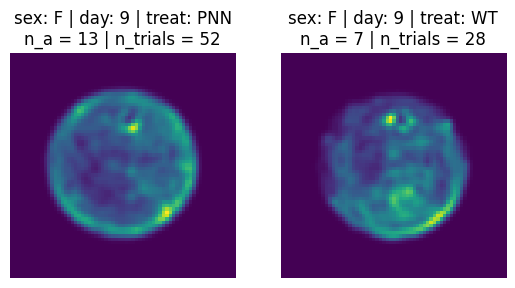

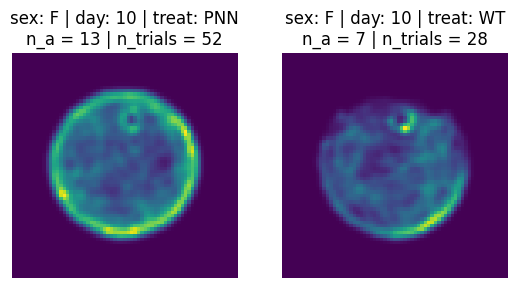

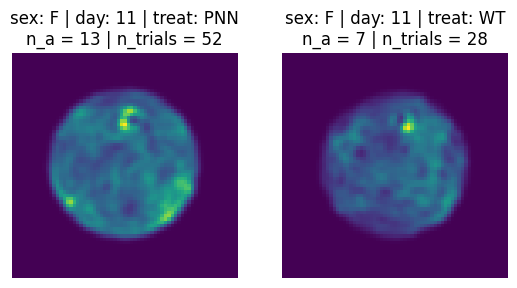

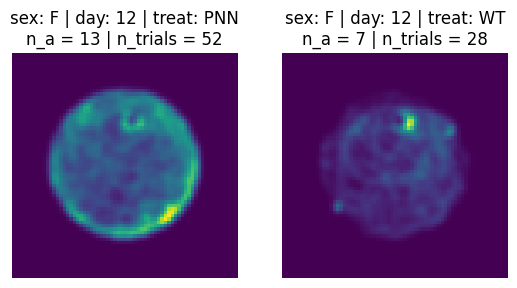

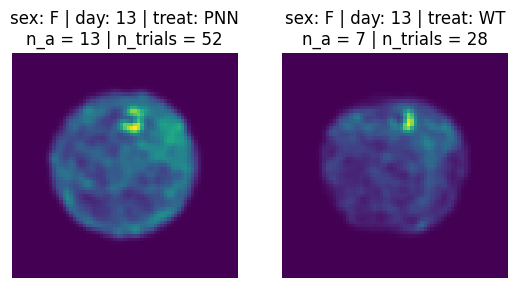

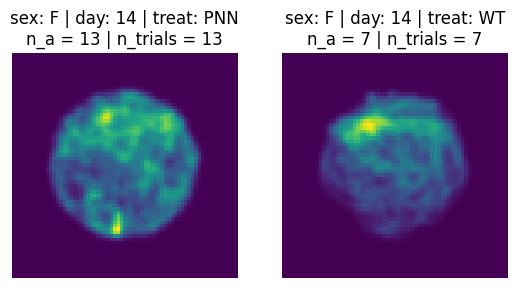

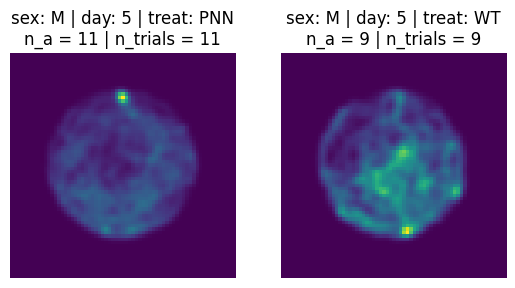

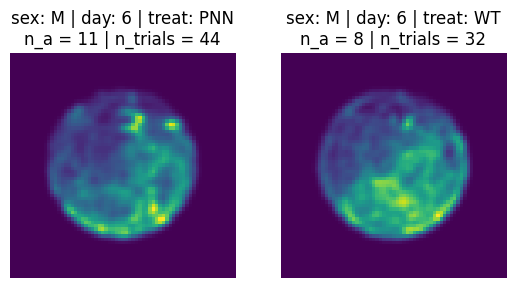

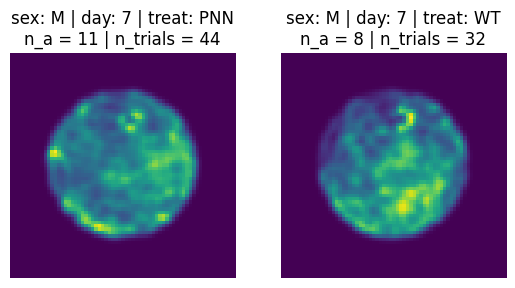

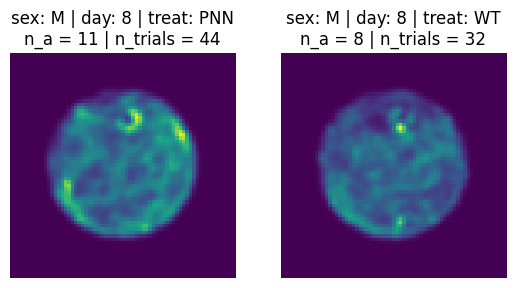

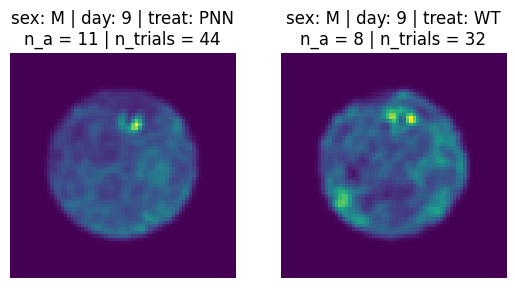

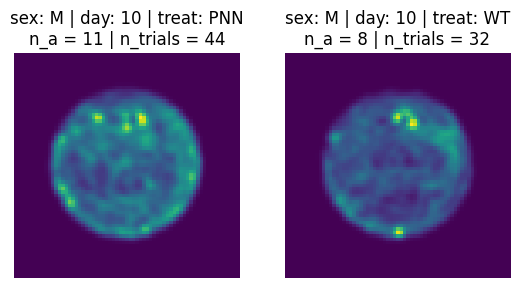

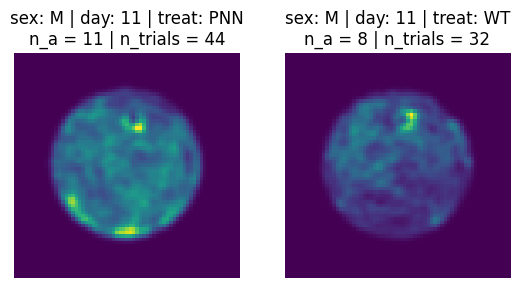

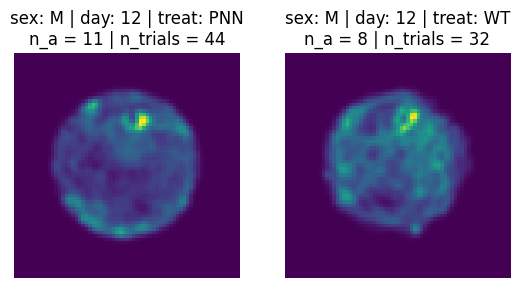

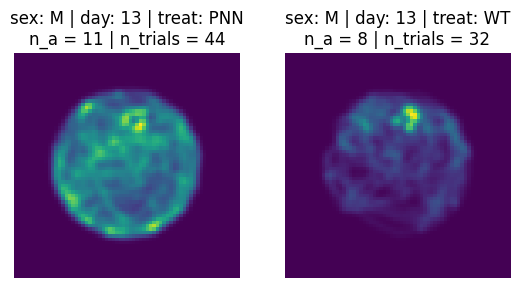

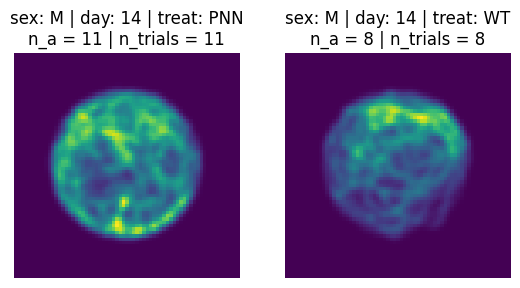

In [18]:
for sex_i in df_meanmap['sex'].unique():
    for day_j in np.array(df_meanmap['exp_day'].unique()):
        fig, ax = plt.subplots(1, 2)
        for m, treat_m in enumerate(df_meanmap['Geno'].unique()):
            dict_res = df_meanmap[
                (df_meanmap['sex'] == sex_i) &
                (df_meanmap['exp_day'] == day_j) &
                (df_meanmap['Geno']==treat_m)
             ].iloc[0]
            occ_mp = dict_res['occupancy_map']
            imshw = ax[m].imshow(occ_mp.T)
            ax[m].axis('off')
            ax[m].set_title(
                'sex: ' + sex_i + ' | ' + 'day: '+ str(int(day_j)) + ' | ' + 'treat: ' + treat_m + '\n' +
                'n_a = ' + str(dict_res['n_animals']) + ' | n_trials = ' + str(dict_res['n_trials']))            

In [19]:
occ_mp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
fig, ax = plt.subplots(
        len(groups)+1, 3,
        **dct_kwargs['subplots'])
    for i, key in enumerate(dct_treat.keys()):
        ax[0, i+1].set_title(key)

    for i, (d_i, n_i) in enumerate(groups.items()):
        df_sel = dataframe[dataframe['grp_day']==d_i]
        
        ax[i, 0].axis('off')
        ax[i, 0].text(0.3, 0.6, n_i)
        
        for j, (key, value) in enumerate(dct_treat.items()):
            occ_mp = df_sel[df_sel['treatment']==value]['occupancy_map']
    
            imshw = ax[i, j+1].imshow(
                    occ_mp.iloc[0].T,
                    **dct_kwargs['imshow'])

            ax[i, j+1].set_aspect('equal')
            ax[i, j+1].axis('off')

            # draw platform locations

            # create axis
            ax_dupl = ax[i, j+1].twinx()
            ax_dupl.axis('off')
            ax_dupl.set_aspect('equal')
            lim = r_pool*fac_scale_border
            ax_dupl.set_xlim(-lim, lim)
            ax_dupl.set_ylim(-lim, lim)


            s_pltfrm = d_pltfrm*1.5
            ell_pltfrm = patches.Ellipse(
                (pos_pltfrm[0],
                 pos_pltfrm[1]),
                s_pltfrm, s_pltfrm,
                linewidth=0, edgecolor='r', facecolor='r')

            ax_dupl.add_patch(ell_pltfrm)

            if np.any(pos_pltfrm_old):
                ell_pltfrm_relearning = patches.Ellipse(
                    (pos_pltfrm_old[0],
                     pos_pltfrm_old[1]),
                    s_pltfrm, s_pltfrm,
                    linewidth=1,
                    linestyle=':',
                    edgecolor='r', facecolor=(0,0,0,0))

                ax_dupl.add_patch(ell_pltfrm_relearning)

        # add colorbar 
        #cax = plt.axes([.37, -.07, .5, 1.])
        cax = plt.axes([.37, .05, .5, 1.])

        cax.axis('off')
        cbar = fig.colorbar(
            imshw, ax=cax,
            **dct_kwargs['colorbar']
        )
        [ax_i.axis('off') for ax_i in ax[-1, :]]

IndentationError: unexpected indent (2893458664.py, line 4)

In [ ]:
plot.plot_occupancy_maps(
    df_meanmap, sorted_groups_only_learning, dct_treat,
    r_pool, fac_scale_border, fac_scale_pltfrm,
    pos_pltfrm, d_pltfrm, pos_pltfrm_old=None,
    fname='figures/occupancy_learning.pdf',
    dct_kwargs=dct_kwargs)